# Scikit Learn Tutorial

This tutorial is intended to get the reader up to speed with the data science workflow using Scikit Learn. 

The main areas we will cover are:
* Feature engineering
* Pre-processing data
* Running and evaluating models

The Scikit Learn API (application programming interface) makes it easy to quickly swap and compare models. For this reason the tutorial will cover linear regression and random forests, with the same overarching method being applicable to other models.

Scikit Learn documentation -> https://scikit-learn.org/stable/

<br>

#### The Data Science Workflow

0a) Feature engineering

0b) Pre-processing data

1) Separate data into test/train split

2) Create model

3) Evaluate model

4) Iterate creation and evaluation until accuracy is good enough

<img src='img/workflow.PNG' width='800'>

<br>

### Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

<br>

### Reading in Data

In [2]:
df_DAM = pd.read_csv('data/df_energy.csv', parse_dates=['datetime'])
df_DAM.head()

,datetime,price,demand,biomass,coal,gas,hydro,nuclear,solar,wind,dutch,french,irish,pumped
0,2015-12-31 00:30:00,40.00,26.935,2.042,4.213,6.064,0.999,7.681,0.0,3.963,0.793,1.621,-0.044,-0.397
1,2015-12-31 01:00:00,40.00,26.254,2.043,4.236,5.860,1.004,7.677,0.0,3.986,0.794,1.622,0.103,-1.071
2,2015-12-31 01:30:00,45.00,25.443,2.043,4.191,5.332,1.003,7.679,0.0,4.172,0.806,1.621,0.001,-1.405
3,2015-12-31 02:00:00,41.89,24.744,2.043,4.012,4.869,1.000,7.697,0.0,4.216,0.781,1.621,-0.093,-1.402
4,2015-12-31 02:30:00,42.00,24.196,2.044,3.899,4.279,0.998,7.705,0.0,4.339,0.773,1.621,-0.063,-1.399


<br>

### Feature Engineering

Feature engineering is often one of the most important parts of machine learning, it's where we create new variables from the ones we currently have.

<br>

Electricity is traded in half hour blocks called Settlement Periods (SP). To make the time component easier for the machine learning algorithm to understand we'll use the SP instead of time.

In [3]:
s_hour = df_DAM.datetime.dt.hour
s_minutes = df_DAM.datetime.dt.minute

s_SP = s_hour*2 + s_minutes/30 + 1
df_DAM['SP'] = s_SP
df_DAM['SP'] = df_DAM['SP'].astype('int')

df_DAM.head()

,datetime,price,demand,biomass,coal,gas,hydro,nuclear,solar,wind,dutch,french,irish,pumped,SP
0,2015-12-31 00:30:00,40.00,26.935,2.042,4.213,6.064,0.999,7.681,0.0,3.963,0.793,1.621,-0.044,-0.397,2
1,2015-12-31 01:00:00,40.00,26.254,2.043,4.236,5.860,1.004,7.677,0.0,3.986,0.794,1.622,0.103,-1.071,3
2,2015-12-31 01:30:00,45.00,25.443,2.043,4.191,5.332,1.003,7.679,0.0,4.172,0.806,1.621,0.001,-1.405,4
3,2015-12-31 02:00:00,41.89,24.744,2.043,4.012,4.869,1.000,7.697,0.0,4.216,0.781,1.621,-0.093,-1.402,5
4,2015-12-31 02:30:00,42.00,24.196,2.044,3.899,4.279,0.998,7.705,0.0,4.339,0.773,1.621,-0.063,-1.399,6


<br> 

There's often a seasonal component in electricity prices so we'll also tell the algorithm whether it's winter or not. We'll define winter as being from October to March.

We'll use a dictionary to 'map' the month values (1-12) to winter/summer. We'll use a 'dummy' variable where 1=Winter and 0=Summer.

Dictionarys contain unique 'keys' which correspond to defined values 

In [4]:
dictionary = {
    1 : 'winter'
}

print(dictionary)
print(dictionary[1])

{1: 'winter'}
winter


In [5]:
winter_months = [10, 11, 12, 1, 2, 3]
summer_months = [4, 5, 6, 7, 8, 9]

all_months = winter_months + summer_months
seasons = [1]*6 + [0]*6                            # Here we're assigning winter '1' and summer '0'

month_to_season = dict(zip(all_months, seasons))
month_to_season

{10: 1, 11: 1, 12: 1, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

In [6]:
s_season = df_DAM.datetime.dt.month.map(month_to_season)
df_DAM['season'] = s_season

df_DAM.head()

,datetime,price,demand,biomass,coal,gas,hydro,nuclear,solar,wind,dutch,french,irish,pumped,SP,season
0,2015-12-31 00:30:00,40.00,26.935,2.042,4.213,6.064,0.999,7.681,0.0,3.963,0.793,1.621,-0.044,-0.397,2,1
1,2015-12-31 01:00:00,40.00,26.254,2.043,4.236,5.860,1.004,7.677,0.0,3.986,0.794,1.622,0.103,-1.071,3,1
2,2015-12-31 01:30:00,45.00,25.443,2.043,4.191,5.332,1.003,7.679,0.0,4.172,0.806,1.621,0.001,-1.405,4,1
3,2015-12-31 02:00:00,41.89,24.744,2.043,4.012,4.869,1.000,7.697,0.0,4.216,0.781,1.621,-0.093,-1.402,5,1
4,2015-12-31 02:30:00,42.00,24.196,2.044,3.899,4.279,0.998,7.705,0.0,4.339,0.773,1.621,-0.063,-1.399,6,1


<br>

Due to a phenomena called the 'Merit Order Effect' the amount of renewables on the grid are likely to play a large role in the price of electricity. This is because renewables have very low operating costs so bid into the market at the bottom of the merit order stack.

<img src='img/merit_order.png' width='800'>

To help our model capture this information we'll create two new columns. One will be the amount of generation provided by 'dispatchable' resources (demand - intermittent renewables), the other will be the percentage of demand met by renewables.

In [7]:
df_DAM['disp_gen'] = df_DAM['demand'] - ( df_DAM['solar'] + df_DAM['wind'] )
df_DAM['pct_renew'] = ( df_DAM['solar'] + df_DAM['wind'] ) / df_DAM['demand']

df_DAM.head()

,datetime,price,demand,biomass,coal,gas,hydro,nuclear,solar,wind,dutch,french,irish,pumped,SP,season,disp_gen,pct_renew
0,2015-12-31 00:30:00,40.00,26.935,2.042,4.213,6.064,0.999,7.681,0.0,3.963,0.793,1.621,-0.044,-0.397,2,1,22.972,0.147132
1,2015-12-31 01:00:00,40.00,26.254,2.043,4.236,5.860,1.004,7.677,0.0,3.986,0.794,1.622,0.103,-1.071,3,1,22.268,0.151824
2,2015-12-31 01:30:00,45.00,25.443,2.043,4.191,5.332,1.003,7.679,0.0,4.172,0.806,1.621,0.001,-1.405,4,1,21.271,0.163974
3,2015-12-31 02:00:00,41.89,24.744,2.043,4.012,4.869,1.000,7.697,0.0,4.216,0.781,1.621,-0.093,-1.402,5,1,20.528,0.170385
4,2015-12-31 02:30:00,42.00,24.196,2.044,3.899,4.279,0.998,7.705,0.0,4.339,0.773,1.621,-0.063,-1.399,6,1,19.857,0.179327


<br>

### Data Pre-Processing

Now we've created the features for the machine learning (ML) model we need to prepare the data so that it's in the correct format.

<br>

One of the things sklearn won't accept is any NaN values. We can check there are none using df.isnull() and then using sum to count up all the true values.

In this case we have no NaN values but when we do we need to decide how to handle them, the main choice is whether to drop the data or if you'll 'impute' it in.

In [8]:
df_DAM.isnull().sum()

datetime     0
price        0
demand       0
biomass      0
coal         0
gas          0
hydro        0
nuclear      0
solar        0
wind         0
dutch        0
french       0
irish        0
pumped       0
SP           0
season       0
disp_gen     0
pct_renew    0
dtype: int64

<br>

When you do have missing data that's in a time series format one of the best approaches is to use s.interpolate() which takes the mean of the known values around it, other common methods are s.ffill() and s.bfill() which forward and backfill.

When you're not working with time series data things become a bit more complicated, one approach is to fill in missing values with the mean of the column, if possible (you have enough data) it is often best to simply drop NaN values using df.dropna().

In [9]:
s = pd.Series([1, np.nan, np.nan, 3])
s

0    1.0
1    NaN
2    NaN
3    3.0
dtype: float64

In [10]:
s.interpolate()

0    1.000000
1    1.666667
2    2.333333
3    3.000000
dtype: float64

In [11]:
s.bfill()

0    1.0
1    3.0
2    3.0
3    3.0
dtype: float64

In [12]:
mean_val = s.mean()
s.fillna(mean_val)

0    1.0
1    2.0
2    2.0
3    3.0
dtype: float64

In [25]:
s.dropna()

0    1.0
3    3.0
dtype: float64

<br>

The next step is to separate the X and y columns, then transform the dataframes into numpy arrays which will be accepted by sklearn, we can use df.values to do this.

In [28]:
df_DAM.drop(columns=['price', 'datetime']).columns

Index(['demand', 'biomass', 'coal', 'gas', 'hydro', 'nuclear ', 'solar',
       'wind', 'dutch', 'french', 'irish', 'pumped', 'SP', 'season',
       'disp_gen', 'pct_renew'],
      dtype='object')

In [31]:
X_cols = df_DAM.drop(columns=['price', 'datetime']).columns
y_col = 'price'

X = df_DAM[X_cols].values 
y = df_DAM[y_col].values

print(X.shape)
print(y.shape)

(34895, 16)
(34895,)


<br>

Now comes one of the most important parts in data science, properly separating test and train data. This ensures that if your model is overfitting to the training data you can find out how it will fare against unseen data.

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_test.shape)

(24426, 16)
(10469, 16)


<br>

Feature normalisation is one technique in the data science (DS) toolkit which can help our algorithms produce better results.

There are a number of ways in which this is useful, one of the most common is related to 'distance' metrics. For example in k-means clustering if one dimension has a scale 10x as large as another then the algorithm will in effect put 10x as much weight on that variable.

MinMaxScaler scales the data so that the max value of each column is 1 and it's minimum is 0.

StandardScaler sets the mean to 0 and the standard deviation to 1.

In [37]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

pd.DataFrame(X_train_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,24426.000000,24426.000000,24426.000000,24426.000000,24426.000000,24426.000000,24426.000000,24426.000000,24426.000000,24426.000000,24426.000000,24426.000000,24426.000000,24426.000000,24426.000000,24426.000000
mean,0.612821,0.629637,0.189165,0.528911,0.297422,0.851679,0.129034,0.331322,0.879824,0.742165,0.599929,0.499244,0.499876,0.495865,0.563474,0.113821
std,0.150984,0.192602,0.185439,0.187847,0.194213,0.072427,0.194328,0.211043,0.167454,0.281067,0.219069,0.178124,0.294412,0.499993,0.135015,0.063705
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.495960,0.528324,0.043943,0.383733,0.138275,0.804267,0.000000,0.154321,0.864697,0.615520,0.449777,0.376881,0.255319,0.000000,0.458839,0.063842
50%,0.618472,0.727553,0.123450,0.526914,0.262295,0.861723,0.005269,0.297891,0.959028,0.860476,0.634487,0.575031,0.489362,0.000000,0.556835,0.106837
75%,0.716665,0.792678,0.285155,0.669681,0.424804,0.902698,0.213058,0.470442,0.969509,0.977880,0.758371,0.601057,0.744681,1.000000,0.651018,0.155036
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<br>

### Running the Model!

One of Scikit Learn's strengths is it's relatively simple API, we can use the same process for a range of ML model types.

<img src='img/sklearn_API.png' width='500'>

We'll first do a multivariate linear regression model.

In [38]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()               # Instantiate the model
lr.fit(X_train_scaled, y_train)       # Fit the model to the training data
y_pred = lr.predict(X_test_scaled)    # Make predictions using the model on the test data

<br>

Evaluating the model is done using the r2 score by default

In [39]:
sum_of_squares = ((y_test - y_pred) ** 2).sum()
res_sum_of_squares = ((y_test - y_test.mean()) ** 2).sum()
r2_score = 1 - (sum_of_squares / res_sum_of_squares)

print(f'R2 score: {r2_score}')

R2 score: 0.17487511312513437


In [40]:
model_score = lr.score(X_test_scaled, y_test)
print(f'R2 score: {model_score}')

R2 score: 0.17487511312513437


<br>

We can look at other scoring measures using sklearns metrics module.

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')

MAE: 9.086932696441671
MSE: 691.0908825032332


<br>

Comparing the absolute and squared error it appears as though the model is unable to handle some of the more extreme values.

We can check this by plotting the error distribution and a separate scatter plot to let us know where the errors are occuring.

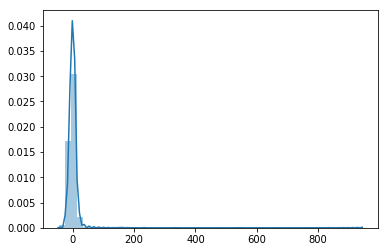

In [42]:
sns.distplot(y_test - y_pred)

(15, 55)

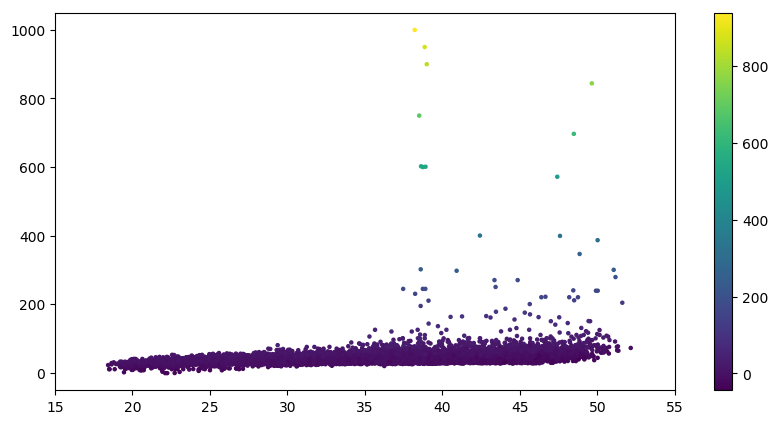

In [43]:
x = X_test[:, 0]
y = y_test
c = y_test - y_pred

## Plotting
plt.figure(figsize=(10, 5), dpi=100)

plt.scatter(x, y, c=c, s=5)
plt.colorbar()

plt.xlim(15, 55)

<br>

### Random Forest Model

One of the most used models at the moment in ML is the random forest, it's an ensemble of individual decision trees.

<img src='img/decision_tree.png' width='500'>

In [44]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=25)  
rf.fit(X_train_scaled, y_train)       
y_pred = rf.predict(X_test_scaled)    

In [45]:
r2 = rf.score(X_test_scaled, y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R2 score: {r2}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')

R2 score: 0.6996334581756483
MAE: 4.781037654026172
MSE: 251.57473949190947


(15, 55)

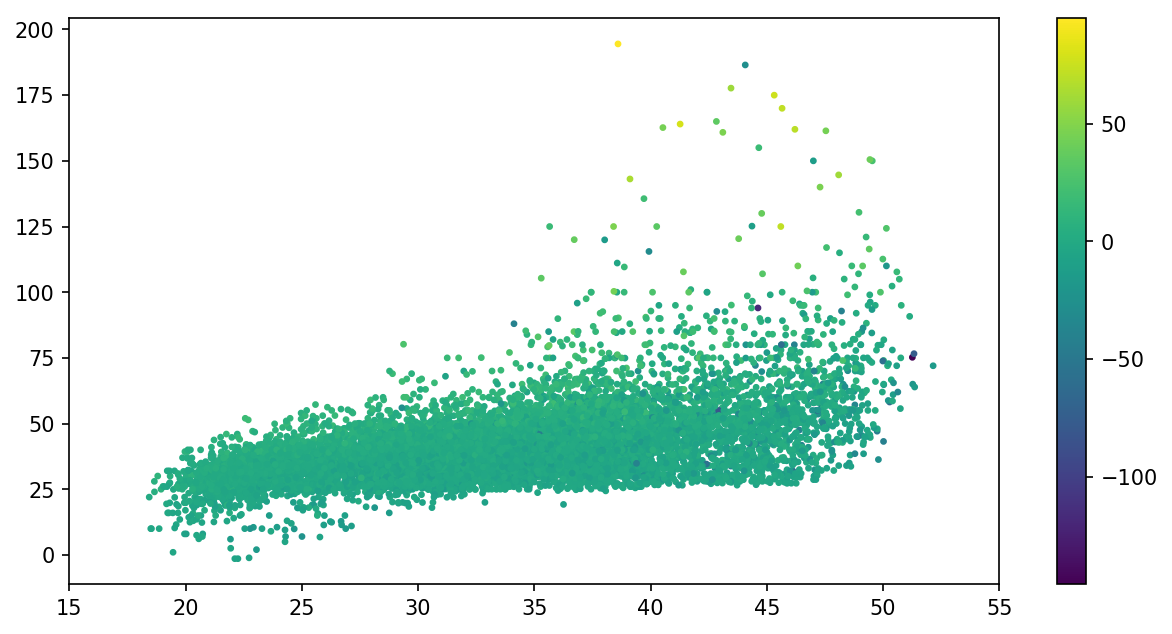

In [46]:
x = X_test[:, 0]
y = y_test
c = y_test - y_pred

df_pred = pd.DataFrame({'x':x, 'y':y, 'c':c})
df_pred_filt = df_pred[df_pred.y<200]

## Plotting
plt.figure(figsize=(10, 5), dpi=150)

plt.scatter(df_pred_filt.x, df_pred_filt.y, c=df_pred_filt.c, s=5, )
plt.colorbar()

plt.xlim(15, 55)

<br>

Feature importance is one of the ways in which random forest models can be explored, the importance is based on the number of decision nodes which use that feature.

In [48]:
rf.feature_importances_

array([0.06345164, 0.06651208, 0.08990678, 0.12521   , 0.04459492,
       0.04396061, 0.01907681, 0.03791889, 0.03211809, 0.06348096,
       0.05686565, 0.16754522, 0.05455872, 0.01762676, 0.08419377,
       0.03297913])

In [50]:
importances = rf.feature_importances_
df_importances = pd.DataFrame({'feature':X_cols, 'importance':importances*100})
df_importances.sort_values('importance', ascending=False)

,feature,importance
11,pumped,16.754522
3,gas,12.521000
2,coal,8.990678
14,disp_gen,8.419377
1,biomass,6.651208
9,french,6.348096
0,demand,6.345164
10,irish,5.686565
12,SP,5.455872
4,hydro,4.459492


<br>

### Putting the Model Together

In [53]:
def random_forest_model(df, X_cols, y_col):
    ## Separating X and y values
    X = df_DAM[X_cols].values 
    y = df_DAM[y_col].values
    
    ## Splitting test and training data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42)
    
    ## Scaling data
    scaler = MinMaxScaler()
    scaler.fit(X_train)

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    ## Running the model
    rf = RandomForestRegressor(n_estimators=25)  
    rf.fit(X_train_scaled, y_train)       
    y_pred = rf.predict(X_test_scaled)
    
    ## Calculating metrics
    r2 = rf.score(X_test_scaled, y_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print(f'R2 score: {r2}')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    
    return 
  
## Defining input variables
X_cols = df_DAM.drop(columns=['price', 'datetime']).columns

y_col = 'price'
    
random_forest_model(df_DAM, X_cols, y_col)

R2 score: 0.6475956490154511
MAE: 4.449329169054441
MSE: 173.96823511679088


<br>

### What Next?

With this model:

* Try out different hyper-parameters and feature engineering methods to see how the model's accuracy changes.
* Try predicting something like the amount of pumped hydro used based on the other features.
* Try out different models to a random forest